## Load Dependencies

In [1]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import RobustScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Loading data, performing defensive data merge and feature extraction

In [2]:
data = pd.read_csv('../data.csv')
data = data[data.shot_made_flag.notnull()].reset_index()
data['opponent'] = data.apply(lambda row: 'NOH' if row['season'] ==
                              '2004-05' and row['opponent'] == 'NOP' else row['opponent'], axis=1)
defense = pd.read_pickle('../feature_engineering/defense_scrape/defense.pkl')
data = data.merge(defense, left_on=['opponent', 'season'], right_on=[
                  'Team_Abb', 'Season'], how='left')
features = ['period', 'playoffs', 'seconds_remaining', 'minutes_remaining', 'season',
            'shot_distance', 'shot_made_flag', 'shot_zone_area', 'game_date', 'matchup',
            'action_type', 'Def_Rtg']

dataset = data[features]
dataset['total_seconds_remaining'] = 60 * \
    dataset['minutes_remaining'] + dataset['seconds_remaining']
dataset.drop('minutes_remaining', axis=1, inplace=True)
dataset.drop('seconds_remaining', axis=1, inplace=True)
dataset['month'] = dataset['game_date'].map(lambda x: x.split('-')[1])
dataset.drop('game_date', axis=1, inplace=True)
dataset['home'] = dataset['matchup'].str.contains('vs').astype('int')
dataset.drop('matchup', axis=1, inplace=True)
dataset["action_type"] = dataset["action_type"].astype('category')
dataset["period"] = dataset["period"].astype('category')
dataset["playoffs"] = dataset["playoffs"].astype('category')
dataset["season"] = dataset["season"].astype('category')
dataset["shot_made_flag"] = dataset["shot_made_flag"].astype('category')
dataset["month"] = dataset["month"].astype('category')
dataset["home"] = dataset["home"].astype('category')
multi_categorical_features = ['action_type',
                              'period', 'season', 'month', 'shot_zone_area']
numerical_features = ['total_seconds_remaining', 'shot_distance']
for c in multi_categorical_features:
    dummies = pd.get_dummies(dataset[c], drop_first=True)
    dummies = dummies.add_prefix("{}#".format(c))
    dataset.drop(c, axis=1, inplace=True)
    dataset = dataset.join(dummies)

### Define train and test split based on chronological order to avoid leakage (as per Kaggle competition rules)

In [3]:
n = len(data)
split = 0.8
train = dataset.iloc[:int(split*n), :]
test = dataset.iloc[int(split*n):, :]
X_train = train.drop('shot_made_flag', axis=1)
y_train = train['shot_made_flag']
X_test = test.drop('shot_made_flag', axis=1)
y_test = test['shot_made_flag']

### Define helper function

In [4]:
def featureImportance(model):
    feature_importance = list(zip(list(dataset), model.feature_importances_))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    for f in feature_importance:
        print(f'{f[0]}: {f[1]}')

## Model 1: Logistic Regression

### First, trying to model with just `shot_distance` as a predictor

In [24]:
features = ['shot_distance']
X_train_reduced = X_train['shot_distance']
X_test_reduced = X_test['shot_distance']

Does ok, 60% accuracy with only one variable!

In [26]:
scoring = 'accuracy'
acc_test_results, acc_train_results = [], []
lr = LogisticRegression(C=10e4)
kfold = KFold(n_splits=10)
acc_cv_results = cross_val_score(lr, np.array(
    X_train_reduced).reshape(-1, 1), y_train, cv=kfold, scoring=scoring)

scoring = 'neg_log_loss'
nll_test_results, nll_train_results = [], []
kfold = KFold(n_splits=10)
nll_cv_results = -cross_val_score(lr, np.array(
    X_train_reduced).reshape(-1, 1), y_train, cv=kfold, scoring=scoring)

In [27]:
print(
    f'CV Accuracy: {np.mean(acc_cv_results):.4f} ± {np.std(acc_cv_results):.4f}')
print(
    f'CV Log Loss: {np.mean(nll_cv_results):.4f} ± {np.std(nll_cv_results):.4f}')

CV Accuracy: 0.5984 ± 0.0143
CV Log Loss: 0.6674 ± 0.0072


### We can also use this single variable logistic regression model to see at what distance the probability of a successful shot is 50%:

In [16]:
lr = LogisticRegression(C=10e4)
lr.fit(np.array(X_train_reduced).reshape(-1, 1), y_train)
dist = np.linspace(dataset.shot_distance.min(),
                   dataset.shot_distance.max(), 1000)
probs = lr.predict_proba(dist.reshape(-1, 1))
thresh = -lr.intercept_/lr.coef_

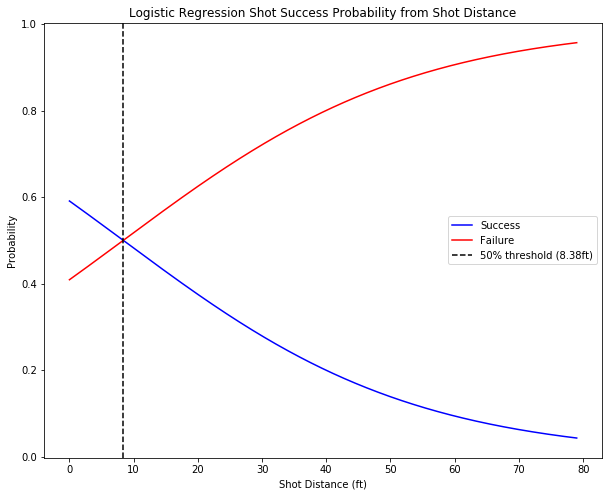

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(dist, probs[:, 1], label='Success', color='blue')
ax.plot(dist, probs[:, 0], label='Failure', color='red')
ax.axvline(x=thresh, linestyle='--', color='black',
           label=f'50% threshold ({float(thresh):.2f}ft)')
ax.set_xlabel('Shot Distance (ft)')
ax.set_ylabel('Probability')
ax.legend()
plt.title('Logistic Regression Shot Success Probability from Shot Distance')
plt.savefig("../presentation_graphs/logreg_shotprob.png")
plt.show()

### Now, using the full dataset to fit a logistic regression model. Let's do a grid search first

In [18]:
lr = LogisticRegression()
grid_params = {'penalty': ['l1', 'l2'],
               'C': np.exp(np.linspace(-5, 5, 20))
               }
gs = GridSearchCV(estimator=lr,
                  param_grid=grid_params,
                  scoring='neg_log_loss',
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([6.73795e-03, 1.14052e-02, 1.93054e-02, 3.26780e-02, 5.53136e-02,
       9.36284e-02, 1.58483e-01, 2.68262e-01, 4.54084e-01, 7.68621e-01,
       1.30103e+00, 2.20224e+00, 3.72769e+00, 6.30981e+00, 1.06805e+01,
       1.80787e+01, 3.06016e+01, 5.17989e+01, 8.76792e+01, 1.48413e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [20]:
gs.best_params_

{'C': 0.011405219123170522, 'penalty': 'l1'}

In [22]:
scoring = 'accuracy'
lr = gs.best_estimator_
kfold = KFold(n_splits=10)
acc_CV_results = cross_val_score(
    lr, X_train, y_train, cv=kfold, scoring=scoring)

scoring = 'neg_log_loss'
nll_CV_results = -cross_val_score(lr, X_train,
                                  y_train, cv=kfold, scoring=scoring)

In [23]:
print(
    f'CV Accuracy: {np.mean(acc_CV_results):.4f} ± {np.std(acc_CV_results):.4f}')
print(
    f'CV Log Loss: {np.mean(nll_CV_results):.4f} ± {np.std(nll_CV_results):.4f}')

CV Accuracy: 0.6795 ± 0.0142
CV Log Loss: 0.6271 ± 0.0087


## Model 2: Random Forest

### Start off with a grid search to get the optimal parameters.

In [28]:
rf = RandomForestClassifier(criterion='gini', n_estimators=200, n_jobs=-1)
kfold = KFold(n_splits=10)
grid_params = {
    'min_samples_leaf': np.arange(1, 20, 5),
    'max_depth': np.arange(5, 20, 3)
}
gs = GridSearchCV(estimator=rf,
                  param_grid=grid_params,
                  scoring='neg_log_loss',
                  cv=kfold)
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': array([ 1,  6, 11, 16]), 'max_depth': array([ 5,  8, 11, 14, 17])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [29]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
scoring = 'accuracy'
rf = RandomForestClassifier(
    criterion='gini', max_depth=17, min_samples_leaf=6, n_estimators=200)
kfold = KFold(n_splits=10)
acc_CV_results = cross_val_score(
    rf, X_train, y_train, cv=kfold, scoring=scoring)

scoring = 'neg_log_loss'
nll_CV_results = -cross_val_score(rf, X_train,
                                  y_train, cv=kfold, scoring=scoring)

In [31]:
print(
    f'CV Accuracy: {np.mean(acc_CV_results):.4f} ± {np.std(acc_CV_results):.4f}')
print(
    f'CV Log Loss: {np.mean(nll_CV_results):.4f} ± {np.std(nll_CV_results):.4f}')

CV Accuracy: 0.6798 ± 0.0153
CV Log Loss: 0.6113 ± 0.0106


### We can visualize the effect of regularization on the random forest model:

In [32]:
scoring = 'accuracy'
error_CV = []
for i in range(1, 31, 1):
    rf = RandomForestClassifier(n_estimators=100, max_depth=i, n_jobs=-1)
    kfold = KFold(n_splits=10)
    error_CV.append(1-cross_val_score(rf, X_train,
                                      y_train, cv=kfold, scoring=scoring))

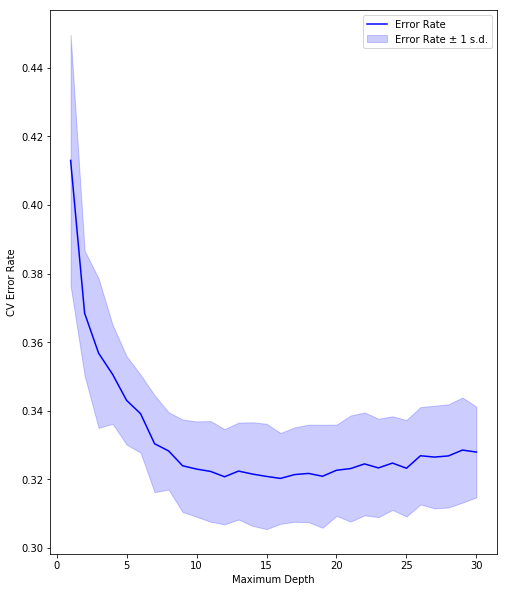

In [41]:
error_train_mean = [np.mean(e) for e in error_CV]
error_train_sd = [np.std(e) for e in error_CV]
fig, ax = plt.subplots(figsize=(8, 10))
ax.plot(range(1, 31), error_CV_mean, color='blue', label='Error Rate')
ax.fill_between(range(1, 31),
                [(a-b) for a, b in zip(error_train_mean, error_train_sd)],
                [(a+b) for a, b in zip(error_train_mean, error_train_sd)],
                alpha=0.2, color='blue', label='Error Rate ± 1 s.d.')
ax.set_ylabel('CV Error Rate')
ax.set_xlabel('Maximum Depth')
ax.legend()
plt.savefig('../presentation_graphs/rf_regular.png')
plt.show()

### The random forest also allows us to check which features are important in this model:

In [33]:
rf = RandomForestClassifier(
    criterion='gini', n_estimators=200, min_samples_leaf=20, n_jobs=-1)
rf.fit(X_train, y_train)
featureImportance(rf)

action_type#Jump Hook Shot: 0.2756995143414146
shot_distance: 0.12748337516883523
action_type#Jump Shot: 0.09055376910555646
Def_Rtg: 0.061017289821082336
action_type#Driving Jump shot: 0.053063688757945274
shot_made_flag: 0.04084645821233821
month#12: 0.03734251174309066
action_type#Running Tip Shot: 0.03360178189962434
action_type#Running Hook Shot: 0.03294055640654639
action_type#Driving Bank shot: 0.027230673812387144
action_type#Pullup Bank shot: 0.016098599229430726
action_type#Hook Shot: 0.015551398051118487
total_seconds_remaining: 0.014272395678202232
action_type#Turnaround Hook Shot: 0.012981396804137468
action_type#Fadeaway Bank shot: 0.012466269175029673
action_type#Tip Layup Shot: 0.007428224267156325
period#3: 0.007008695065987091
season#2014-15: 0.006788108179717778
shot_zone_area#Center(C): 0.006328168351296688
action_type#Driving Slam Dunk Shot: 0.005693779210650938
shot_zone_area#Left Side(L): 0.0056911288191271725
period#2: 0.005639138491032817
month#02: 0.0051161475

### We can visualize what a typical random forest tree might look like using a decision tree

In [46]:
dt = DecisionTreeClassifier(max_leaf_nodes=7, criterion='gini')
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [47]:
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

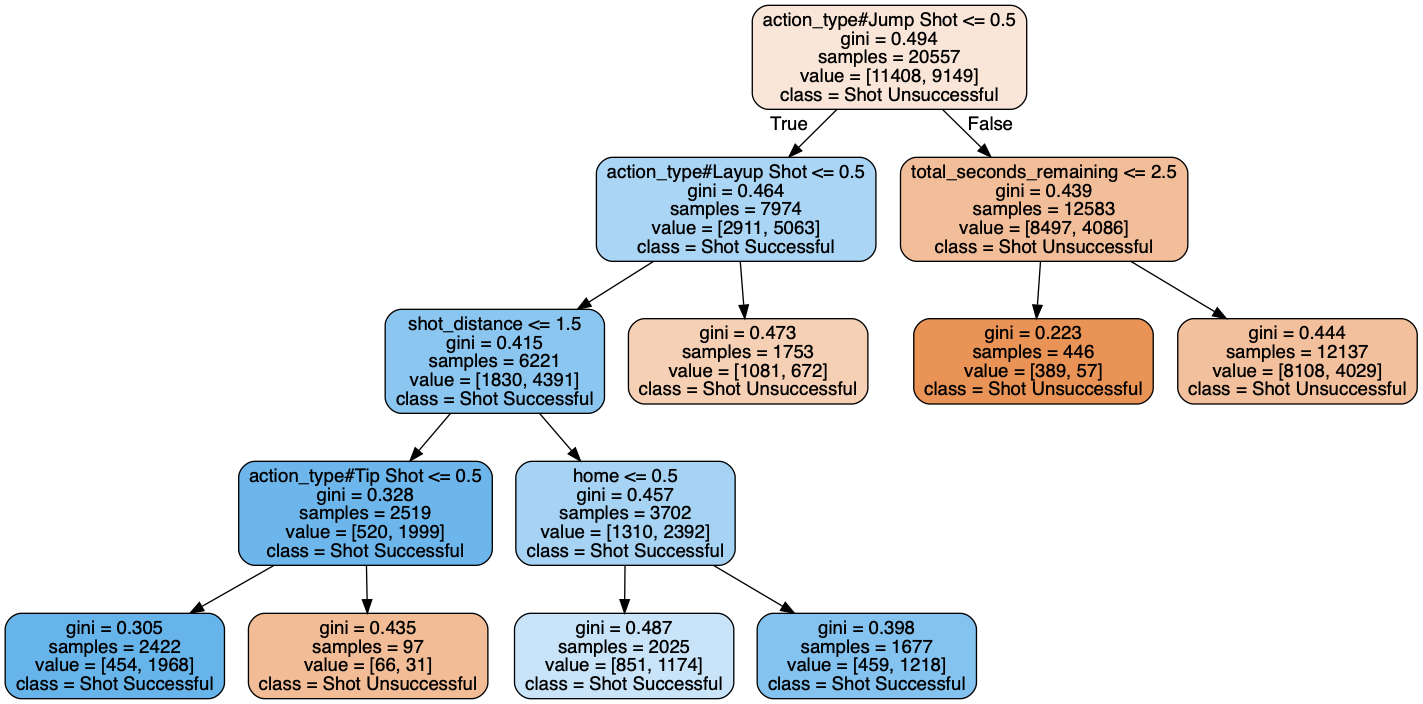

In [50]:
export_graphviz(dt,
                out_file="../presentation_graphs/dtree.dot",
                feature_names=list(X_train),
                class_names=['Shot Unsuccessful', 'Shot Successful'],
                rounded=True,
                filled=True
                )
!dot - Tpng ../presentation_graphs/dtree.dot - o ../presentation_graphs/dtree.png
Image(filename='../presentation_graphs/dtree.png')

## Model 3: Gradient Boosted Trees

### While the Random Forest model works well, we decided to explore a boosting option to improve further. We performed a gridsearch on 1 or 2 features at a time.

In [29]:
gb = GradientBoostingClassifier(
    n_estimators=120, max_depth=4, min_samples_split=4)
grid_params = {'min_samples_split': range(2, 10, 2),
               'max_depth': range(2, 10, 2)}
gs = GridSearchCV(estimator=gb,
                  param_grid=grid_params,
                  scoring='neg_log_loss',
                  cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(2, 10, 2), 'max_depth': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [30]:
gs.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [31]:
print(f'Test Accuracy: {gs.score(X_test, y_test):.4f}')
print(f'Test Log-Loss: {log_loss(y_test, gs.predict_proba(X_test)):.4f}')

Test Accuracy: -0.6125
Test Log-Loss: 0.6125


## Comparing Multiple Models

### Having investigated multiple models, we can now compare their performance through cross-validation on the training set.

In [34]:
models = [('LR', LogisticRegression(C=0.0114, penalty='l1')),
          ('RF', RandomForestClassifier(n_estimators=200,
                                        criterion='gini', min_samples_leaf=6, max_depth=18)),
          ('DT', DecisionTreeClassifier(max_leaf_nodes=10, criterion='gini')),
          ('KNN', KNeighborsClassifier(n_neighbors=100, p=1)),
          ('GB', GradientBoostingClassifier(n_estimators=120, max_depth=4, min_samples_split=4))]

In [35]:
scoring = 'neg_log_loss'
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = -cross_val_score(model, X_train,
                                  y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f'{name}: {cv_results.mean():.4f} ± {cv_results.std():.4f}')

LR: 0.6271 ± 0.0087
RF: 0.6107 ± 0.0108
DT: 0.6137 ± 0.0129
KNN: 0.6614 ± 0.0078
GB: 0.6077 ± 0.0124


## Tests for Model Log Loss

In [38]:
lr_mean_log_loss = cv_results[0].mean()
rf_mean_log_loss = cv_results[1].mean()
gb_mean_log_loss = cv_results[4].mean()

# Test that Random Forest and Gradient Boosting has smaller log loss than Logistic Regression
assert rf_mean_log_loss < lr_mean_log_loss
assert gb_mean_log_loss < lr_mean_log_loss

# Test that Gradient Boosting has the smallest log loss
assert gb_mean_log_loss < rf_mean_log_loss

AssertionError: 

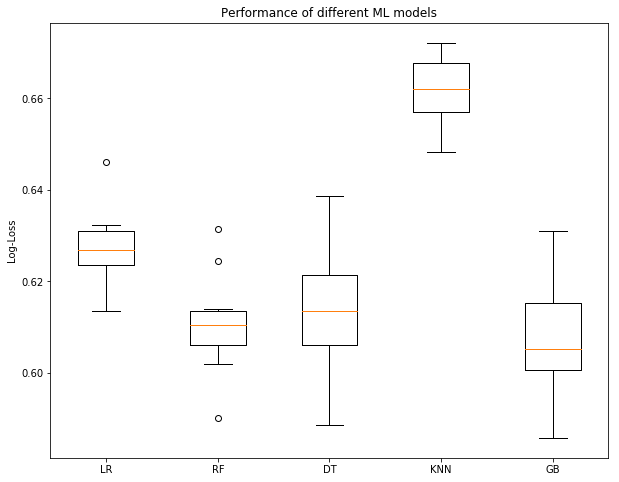

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Log-Loss')
plt.title('Performance of different ML models')
plt.savefig('../presentation_graphs/model_perform.png')
plt.show()

It can be seen that the Logistic regression model with penalization performs reasonably well and has low variance which would be expected as the penalization reduces variance at the cost of increased bias. The Random Forest and Decision Tree models perform reasonably similarly, but the Random Forest model has a lower log-loss and lower variance, which is expected as this is an ensemble method which reduces variance and bias. The KNN approach performs poorly. The Gradient Boosted Tree model performs the best of them all in terms of log-loss, but still has fairly high variance.

Below, we finally evaluate the performance of the GB model on the held out test dataset. A log-loss of 0.6064 and accuracy of 67.7% is achieved, which is in line with our cross-validation estimates from the training set.

In [115]:
gb = GradientBoostingClassifier(
    n_estimators=120, max_depth=4, min_samples_split=4)

In [116]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [118]:
print(f'Test Accuracy: {gb.score(X_test, y_test):.4f}')
print(f'Test Log-Loss: {log_loss(y_test, gb.predict_proba(X_test)):.4f}')

Test Accuracy: 0.6770
Test Log-Loss: 0.6064
